In [26]:
import numpy as np
import george
from george import kernels
from scipy.optimize import minimize
from time import time
import argparse
import pickle
import matplotlib.pyplot as plt

In [27]:
with open ('./gmd/trans4_COBYLA_conv_optimize_result.txt', 'rb') as fp:
    old_fit = pickle.load(fp)

In [40]:
old_fit

array([[ 1.52335991e+01,  1.83017174e+01, -1.91972567e+00,
        -1.05250255e+00, -1.36696656e+00, -5.99361333e+00,
        -4.74550451e+00, -4.87778574e+00, -4.90301252e+00,
        -7.70414170e+00, -6.88356295e+00, -6.92297990e+00,
        -7.05922883e+00, -1.33332897e+00,  3.64987381e+00,
         5.52099926e-01],
       [ 1.23926880e+01,  1.75712662e+01, -1.51125541e+00,
        -1.23146414e+00, -2.25220289e+00, -8.54761793e+00,
        -3.61115104e+00, -4.29792065e+00, -3.42488200e+00,
        -5.02770172e+00, -6.87799575e+00, -6.71526177e+00,
        -4.43110741e+00, -1.72750665e+00,  2.10811629e+00,
         1.61868798e+00],
       [ 9.94643872e+00,  1.70174107e+01, -2.61913103e-01,
        -2.24446656e+00, -1.88711542e+00, -7.56490183e+00,
        -5.37776841e+00, -3.30656045e+00, -5.82503814e+00,
        -4.52142156e+00, -5.56472062e+00, -4.78913103e+00,
        -6.00514292e+00, -2.52151430e-01,  8.38374511e-01,
         6.63974989e-01],
       [ 7.87364250e+00,  1.71863505e

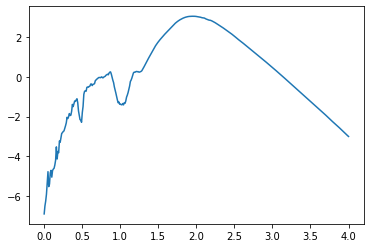

[4873.364486481154, 1.57368370845992, -3.794253679305082, 2.8222423888932875, 0.4164057510133844, -0.814029777862018, 0.6163487433180679, 1.33999966671489, -2.967371234297568, 3.134498716854428, 0.6570918963250121, 1.195516450435977, 1.5034864765254325, 3.1589034293580402, 82.01044597146092]


In [29]:
grid=np.load("./etgrid/seds.npy")
param_names = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin",\
          "gamma","beta","logMenv","logRenv","fcav","ksi","logamax","p","incl"]
    
xvals=np.load("./etgrid/xvals.npy")
etdict=np.load("./etgrid/et_dictionary.npy",allow_pickle=True)

def point(i):
    coords=[]
    for j in param_names:
        coords.append(etdict[i][j])
    sed = grid[i][100:500]
    return (coords, sed)

plt.plot(np.log10(xvals),point(0)[1])
plt.show()
print(point(0)[0])

In [30]:
with open ('./gmd/trans4_parvals.txt', 'rb') as fp:
    coords= pickle.load(fp) 
with open ('./gmd/trans4_eigenseds.txt', 'rb') as fp:
    eigenseds= pickle.load(fp)
with open ('./gmd/trans4_weights.txt', 'rb') as fp:
    weights= pickle.load(fp)
with open ('./gmd/trans4_mean.txt', 'rb') as fp:
    pcamean= pickle.load(fp)

yerrs=[]
for i in range(16):
    yerrs.append([x*0.01 for x in weights[i]])


In [12]:
kernel = 16*kernels.ExpSquaredKernel(15**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=14) 
blankhodlr=george.GP(kernel)

In [13]:
sample=np.random.randint(0,3917,10)
sample_coords=[]
for i in range(len(sample)):
    sample_coords.append(point(sample[i])[0])

In [16]:
def pred(pred_coords):
    gp=blankhodlr
    preds=[]
    hyperparams=np.transpose(np.array(old_fit).reshape(16,16))
    for i in range(len(weights)):  # same covfunc for each weight and the sample mean
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(coords,yerrs[i])
        pred, pred_var = gp.predict(weights[i], pred_coords, return_var=True)
        preds.append(pred)
    reconst_SEDs=[]
    for i in range(len(pred_coords)):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pcamean + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    return reconst_SEDs


In [17]:
predicted_SEDs=pred(sample_coords)

LinAlgError: 1711-th leading minor of the array is not positive definite

In [ ]:
for i in range(len(predicted_SEDs)):
    print(sample[i])
    print(orig_dict[sample[i]])
    plt.plot(np.log10(xvals),predicted_SEDs[i],c='r',label="prediction")
    plt.plot(np.log10(xvals),point(sample[i])[1],c='k',label="RT")
    plt.legend()
    plt.show()